In [2]:
from sklearn.preprocessing import StandardScaler
import pyupbit
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import shap
from scipy.special import softmax

In [3]:
class RevIN(nn.Module):
    def __init__(self, num_features: int, eps=1e-5, affine=True):
        """
        :param num_features: the number of features or channels
        :param eps: a value added for numerical stability
        :param affine: if True, RevIN has learnable affine parameters
        """
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        if self.affine:
            self._init_params()

    def forward(self, x, mode:str):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else: raise NotImplementedError
        return x

    def _init_params(self):
        # initialize RevIN params: (C,)
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim-1))
        self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps*self.eps)
        x = x * self.stdev
        x = x + self.mean
        return x

In [31]:
# 데이터 로드
ticker = 'KRW-BTC'
interval = 'minute3'
to = '2024-10-31 09:00'
count = 13440
data = pyupbit.get_ohlcv(ticker=ticker, interval=interval, to=to, count=count)
# 이동평균 3과 5 계산
data['ma_3'] = data['close'].rolling(window=3).mean()  # 3-period 이동평균
data['ma_5'] = data['close'].rolling(window=5).mean()  # 5-period 이동평균
data['middle'] = (data['high'] + data['low']) / 2

#1달 데이터 3분간격

In [32]:
# NaN 값 제거 (초기 구간에서는 이동평균 계산 불가)
data = data.dropna()

In [33]:
data

,open,high,low,close,volume,value,ma_3,ma_5,middle
2024-10-03 12:39:00,82505000.0,82505000.0,82427000.0,82505000.0,2.966659,2.447083e+08,8.253700e+07,82558400.0,82466000.0
2024-10-03 12:42:00,82500000.0,82505000.0,82423000.0,82499000.0,1.690431,1.393662e+08,8.249833e+07,82546000.0,82464000.0
2024-10-03 12:45:00,82499000.0,82593000.0,82433000.0,82482000.0,3.699225,3.052489e+08,8.249533e+07,82518400.0,82513000.0
2024-10-03 12:48:00,82590000.0,82591000.0,82500000.0,82589000.0,0.558138,4.609081e+07,8.252333e+07,82513200.0,82545500.0
2024-10-03 12:51:00,82590000.0,82610000.0,82540000.0,82609000.0,2.760618,2.280237e+08,8.256000e+07,82536800.0,82575000.0
...,...,...,...,...,...,...,...,...,...
2024-10-31 17:45:00,100419000.0,100445000.0,100402000.0,100416000.0,1.881093,1.888933e+08,1.004213e+08,100428200.0,100423500.0
2024-10-31 17:48:00,100416000.0,100454000.0,100401000.0,100416000.0,2.048091,2.056766e+08,1.004170e+08,100426000.0,100427500.0
2024-10-31 17:51:00,100416000.0,100479000.0,100401000.0,100451000.0,2.179007,2.188510e+08,1.004277e+08,100426200.0,100440000.0
2024-10-31 17:54:00,100451000.0,100541000.0,100451000.0,100541000.0,2.542313,2.554695e+08,1.004693e+08,100448600.0,100496000.0


In [34]:
# 데이터 분리
SPLIT = int(0.7 * len(data))  # 7:3으로 분할
train_data = data[:SPLIT]
test_data = data[SPLIT:]

In [35]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
revin = RevIN(num_features=9, affine=True).to(DEVICE)  # num_features는 feature의 개수


In [36]:
# 데이터를 Tensor로 변환
train_tensor = torch.FloatTensor(train_data.values).to(DEVICE)
test_tensor = torch.FloatTensor(test_data.values).to(DEVICE)

# RevIN 정규화
train_normalized = revin(train_tensor, mode='norm')
test_normalized = revin(test_tensor, mode='norm')


In [37]:
print(train_normalized)
print(test_normalized)

tensor([[-0.1303, -0.1303, -0.1306,  ..., -0.1301, -0.1301, -0.1304],
        [-0.1303, -0.1303, -0.1306,  ..., -0.1303, -0.1301, -0.1304],
        [-0.1303, -0.1299, -0.1306,  ..., -0.1303, -0.1302, -0.1302],
        ...,
        [-0.0877, -0.0877, -0.0879,  ..., -0.0876, -0.0874, -0.0878],
        [-0.0877, -0.0874, -0.0877,  ..., -0.0876, -0.0875, -0.0876],
        [-0.0874, -0.0874, -0.0876,  ..., -0.0875, -0.0876, -0.0875]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor([[-0.1433, -0.1432, -0.1433,  ..., -0.1433, -0.1434, -0.1433],
        [-0.1432, -0.1432, -0.1434,  ..., -0.1433, -0.1434, -0.1433],
        [-0.1434, -0.1434, -0.1436,  ..., -0.1433, -0.1434, -0.1435],
        ...,
        [-0.1200, -0.1198, -0.1200,  ..., -0.1199, -0.1199, -0.1199],
        [-0.1198, -0.1196, -0.1198,  ..., -0.1198, -0.1199, -0.1197],
        [-0.1196, -0.1195, -0.1196,  ..., -0.1196, -0.1198, -0.1195]],
       device='cuda:0', grad_fn=<AddBackward0>)


In [38]:
#데이터 분리
def MakeSeqNumpyData(data, seq_length):
    x_seq_list = []
    y_seq_list = []
    for i in range(len(data) - seq_length):
        x_seq_list.append(data[i:i + seq_length, :-1])  # 입력 데이터
        y_seq_list.append(data[i + seq_length, [-1]])  # 정답 데이터
    return np.array(x_seq_list), np.array(y_seq_list)

SEQ_LENGTH = 288  # 시퀀스 길이
x_train_data, y_train_data = MakeSeqNumpyData(train_normalized.detach().cpu().numpy(), SEQ_LENGTH)
x_test_data, y_test_data = MakeSeqNumpyData(test_normalized.detach().cpu().numpy(), SEQ_LENGTH)


In [39]:
print(x_train_data)
print(y_train_data)
print(x_test_data)
print(y_test_data)

[[[-0.13027278 -0.13027278 -0.13058935 ...  0.5280512  -0.13014291
   -0.13005605]
  [-0.13029307 -0.13027278 -0.1306056  ...  0.10050595 -0.13029984
   -0.13010637]
  [-0.13029714 -0.12991562 -0.130565   ...  0.7737634  -0.13031201
   -0.1302184 ]
  ...
  [-0.13159996 -0.13151473 -0.13177854 ...  0.46522036 -0.13177449
   -0.13181913]
  [-0.13155125 -0.1315269  -0.13208699 ... -0.37685397 -0.13154855
   -0.13173714]
  [-0.1315269  -0.1315269  -0.13181913 ... -0.09911936 -0.13160402
   -0.13172334]]

 [[-0.13029307 -0.13027278 -0.1306056  ...  0.10050595 -0.13029984
   -0.13010637]
  [-0.13029714 -0.12991562 -0.130565   ...  0.7737634  -0.13031201
   -0.1302184 ]
  [-0.1299278  -0.12992375 -0.13029307 ... -0.27806464 -0.13019836
   -0.1302395 ]
  ...
  [-0.13155125 -0.1315269  -0.13208699 ... -0.37685397 -0.13154855
   -0.13173714]
  [-0.1315269  -0.1315269  -0.13181913 ... -0.09911936 -0.13160402
   -0.13172334]
  [-0.1317623  -0.1315269  -0.13176636 ... -0.15528816 -0.13160671
   -0.

In [40]:
#텐서로 변환
x_train_tensor = torch.FloatTensor(x_train_data).to(DEVICE)
y_train_tensor = torch.FloatTensor(y_train_data).to(DEVICE)
x_test_tensor = torch.FloatTensor(x_test_data).to(DEVICE)
y_test_tensor = torch.FloatTensor(y_test_data).to(DEVICE)

# DataLoader 생성
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

BATCH_SIZE = 20
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [41]:
#LSTM 모델
class MyLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # 최종 출력이 스칼라값
    def forward(self, data):
        outputs, _ = self.lstm(data)
        last_hs = outputs[:, -1, :]  # 마지막 시점의 hidden state
        prediction = self.fc(last_hs)
        return prediction

FEATURE_NUMS = 8  # 입력 feature 수
HIDDEN_SIZE = 4   # LSTM hidden state 크기
NUM_LAYERS = 1    # LSTM 층 수

model = MyLSTMModel(FEATURE_NUMS, HIDDEN_SIZE, NUM_LAYERS).to(DEVICE)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [42]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

MyLSTMModel(
  (lstm): LSTM(8, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [43]:
#모델 훈련
def model_train(dataloader, model, loss_function, optimizer):
    model.train()
    total_loss = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

EPOCHS = 200
train_loss_list = []

for epoch in range(EPOCHS):
    avg_loss = model_train(train_loader, model, loss_function, optimizer)
    train_loss_list.append(avg_loss)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}]")


Epoch [10/200]
Epoch [20/200]
Epoch [30/200]
Epoch [40/200]
Epoch [50/200]
Epoch [60/200]
Epoch [70/200]
Epoch [80/200]
Epoch [90/200]
Epoch [100/200]
Epoch [110/200]
Epoch [120/200]
Epoch [130/200]
Epoch [140/200]
Epoch [150/200]
Epoch [160/200]
Epoch [170/200]
Epoch [180/200]
Epoch [190/200]
Epoch [200/200]


In [44]:
# 테스트 예측
test_pred_tensor = model(x_test_tensor)

# 역정규화
test_pred_denormalized = revin(test_pred_tensor, mode='denorm')
y_test_denormalized = revin(y_test_tensor, mode='denorm')

# NumPy 변환
test_pred_numpy = test_pred_denormalized.cpu().detach().numpy()
y_test_numpy = y_test_denormalized.cpu().detach().numpy()


In [45]:
Pred_end = test_pred_numpy[:,-1]
Test_end = y_test_numpy[:, -1]

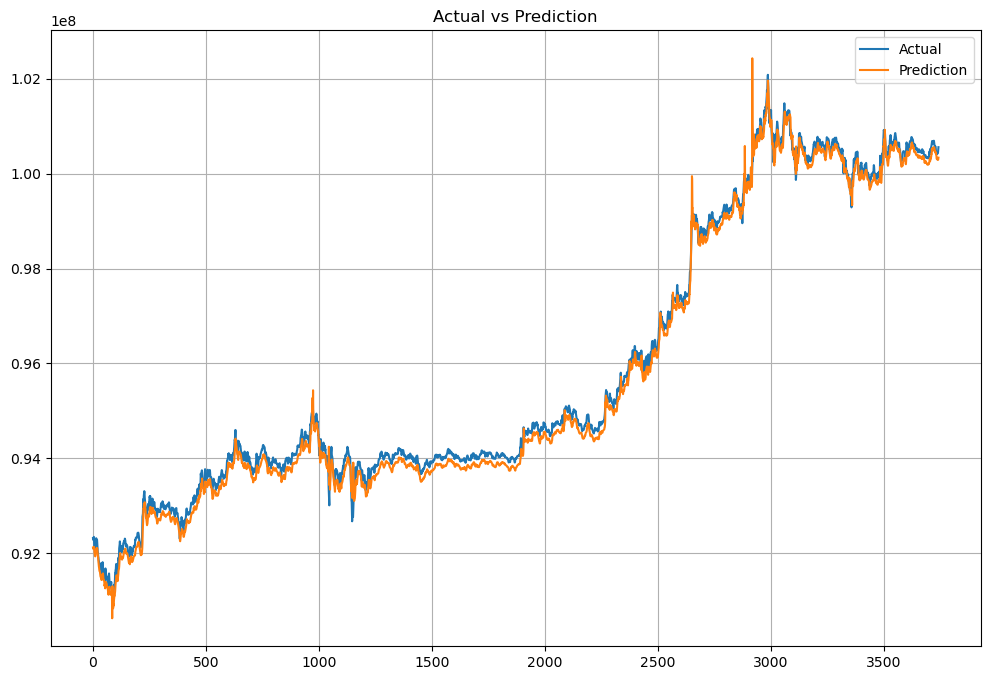

In [46]:
plt.figure(figsize=(12, 8))
plt.plot(Test_end, label='Actual')
plt.plot(Pred_end, label='Prediction')
plt.title('Actual vs Prediction')
plt.grid()
plt.legend()
plt.show()


In [47]:
def calculate_metrics(pred, true):
    """
    MAE, MSE, RMSE, MAPE, MSPE 계산
    :param pred: 예측값 (1D array)
    :param true: 실제값 (1D array)
    :return: 각 지표의 값
    """
    mae = np.mean(np.abs(pred - true))  # Mean Absolute Error
    mse = np.mean((pred - true) ** 2)  # Mean Squared Error
    rmse = np.sqrt(mse)  # Root Mean Squared Error
    mape = np.mean(np.abs((true - pred) / true)) * 100  # Mean Absolute Percentage Error
    mspe = np.mean(((true - pred) / true) ** 2) * 100  # Mean Squared Percentage Error

    return mae, mse, rmse, mape, mspe


In [48]:
# 마지막 피처 값만 추출
pred_values = test_pred_numpy[:, -1]
true_values = y_test_numpy[:, -1]

# 평가 지표 계산
mae, mse, rmse, mape, mspe = calculate_metrics(pred_values, true_values)

# 결과 출력
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"MSPE: {mspe:.4f}%")


MAE: 172491.2344
MSE: 36566769664.0000
RMSE: 191224.3906
MAPE: 0.18%
MSPE: 0.0004%


In [49]:
start_idx = 1500
end_idx = 2000
pred_subset = Pred_end[start_idx:end_idx]
y_test_subset = Test_end[start_idx:end_idx]

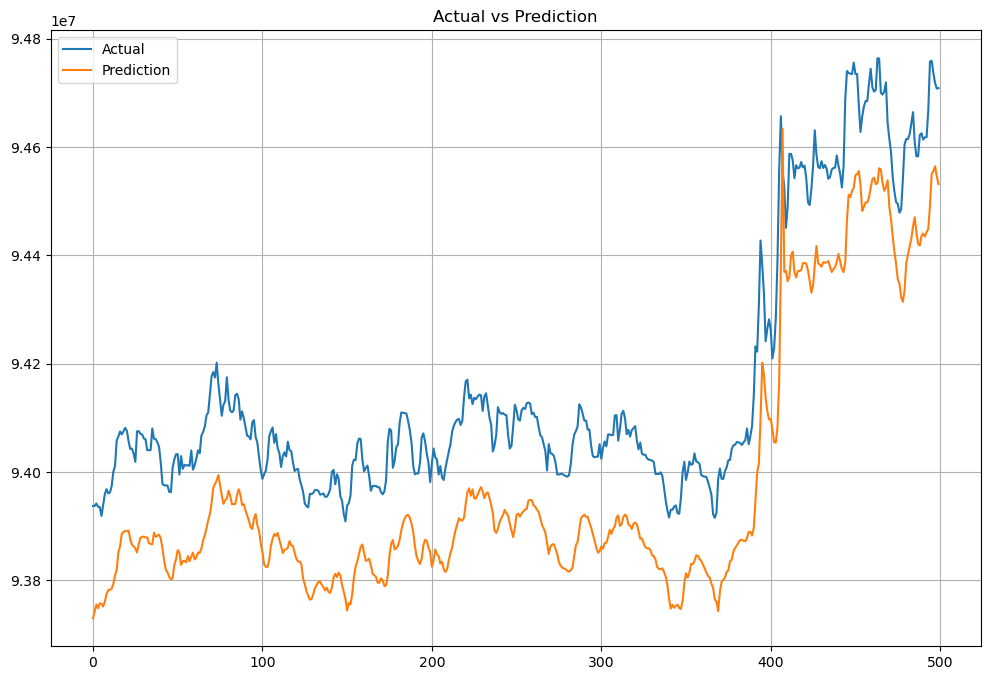

In [50]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_subset, label='Actual')
plt.plot(pred_subset, label='Prediction')
plt.title('Actual vs Prediction')
plt.grid()
plt.legend()
plt.show()


In [51]:
# Define Query, Key, and Value matrices
Q = np.array([[1, 0], [0, 1]])
K = np.array([[1, 2], [2, 3]])
V = np.array([[0, 1], [1, 0]])

# Calculate the dot product of Q and K.T (transpose of K)
QK_T = np.dot(Q, K.T)

# Divide by the square root of d_k (dimension of Key vectors)
d_k = K.shape[1]
QK_T_scaled = QK_T / np.sqrt(d_k)

# Apply the Softmax function
weights = softmax(QK_T_scaled, axis=-1)

# Multiply the weights with Value matrix
output = np.dot(weights, V)

print(" QK_T : ", QK_T)
print("\n QK_T_scaled : ", QK_T_scaled)
print("\n weights : ", weights)
print("\n output : ", output)

 QK_T :  [[1 2]
 [2 3]]

 QK_T_scaled :  [[0.70710678 1.41421356]
 [1.41421356 2.12132034]]

 weights :  [[0.33023845 0.66976155]
 [0.33023845 0.66976155]]

 output :  [[0.66976155 0.33023845]
 [0.66976155 0.33023845]]
